In [2]:
%matplotlib notebook

In [36]:
import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms, io
from ase.build import molecule, make_supercell
from ase.quaternions import Quaternion
from muspinsim.spinsys import SpinSystem, MuonSpinSystem
from muspinsim.spinop import DensityOperator
from muspinsim.experiment import MuonExperiment
from muspinsim.constants import MU_GAMMA
from soprano.selection import AtomSelection
from soprano.properties.linkage import Molecules
from soprano.nmr.utils import _dip_constant, _dip_tensor
from soprano.data.nmr import (_get_isotope_data, _get_nmr_data, _el_iso)
from soprano.utils import periodic_bridson, minimum_periodic, minimum_supcell, supcell_gridgen
from soprano.properties.nmr.dipolar import DipolarRSS, DipolarTensor, DipolarCoupling

In [38]:
# Generate a random cluster of H atoms
L = 3.0
N = 3
cell = np.eye(3)*L*3
positions = np.random.random((N**3,3))-0.5
positions += np.array(np.meshgrid(*[np.arange(N)]*3)).reshape((3,-1)).T*L

atoms = Atoms('H'*N**3, positions=positions,cell=cell)
io.write('randomCluster.cif', atoms)

In [76]:
atoms = io.read('TRIAMT01_geomopt-out.cif')

In [88]:
R = 10
element = 'H'
center_i = 0

sys = AtomSelection.from_element(atoms, element).subset(atoms)
# Make it a supercell
scell = minimum_supcell(R, sys.get_cell())
grid_i, grid_xyz = supcell_gridgen(sys.get_cell(), scell)

In [89]:
rsscalc = DipolarRSS(cutoff=R, isonuclear=True)
print('RSS: {0} kHz'.format(rsscalc(sys)[center_i]*1e-3))

RSS: 25.48120774826686 kHz


In [85]:
# Make a spin system of the whole cluster...
p0 = sys.get_positions()[center_i]
pos = sys.get_positions()[None,:,:]+grid_xyz[:,None,:]
r = pos-p0
rnorm = np.linalg.norm(r, axis=-1)
sphere = np.where(R >= rnorm)
r = r[sphere]
rnorm = rnorm[sphere]
n = len(r)

a = Atoms(element*n, positions=r, cell=np.eye(3)*2*R)

print('Spin number: {0}'.format(n))

if (n > 10):
    raise RuntimeError('Too many spins')

ssys = SpinSystem(a.get_chemical_symbols())
B = 3.0
for i in range(len(ssys)):
    ssys.add_linear_term(i, np.array([0, 0, B])*ssys.gamma(i))
    for j in range(i+1, len(ssys)):
        ssys.add_bilinear_term(i, j, DipolarTensor.get(a)[(i,j)]*1e-6) 

H = ssys.hamiltonian
Sxtot = sum([ssys.operator({i: 'x'}) for i in range(len(ssys))], 0*ssys.operator({}))
traceRss = np.abs(np.trace(((H*Sxtot-Sxtot*H)*(H*Sxtot-Sxtot*H)).matrix)/np.trace((Sxtot*Sxtot).matrix))

print('Trace square commutator: {0:.2f} kHz'.format(traceRss*1e-3))

Spin number: 39


RuntimeError: Too many spins

In [74]:
evals, evecs = H.diag()
Sxdiag = Sxtot.basis_change(evecs)

freqs = (evals[:,None]-evals[None,:]).reshape((-1,))
weights = np.abs(Sxdiag.matrix.T.reshape((-1,)))

# Central frequency?
larmor = B*ssys.gamma(0)
# Which ones are close enough?
peak_inds = np.where((abs(freqs-larmor) < 0.5*larmor)*(1-np.isclose(weights, 0)))

rss = (np.sum(weights[peak_inds]**2*(freqs[peak_inds]-larmor)**2)/np.sum(weights[peak_inds]**2))**0.5
nu2 = (np.sum(weights**2*(freqs)**2)/np.sum(weights**2))
print("RSS: {0:.3f} kHz".format(rss*1e3))
print("<\\nu^2> = {0:.3f} kHz".format(nu2))

RSS: 55.449 kHz
<\nu^2> = 16315.571 kHz


<IPython.core.display.Javascript object>


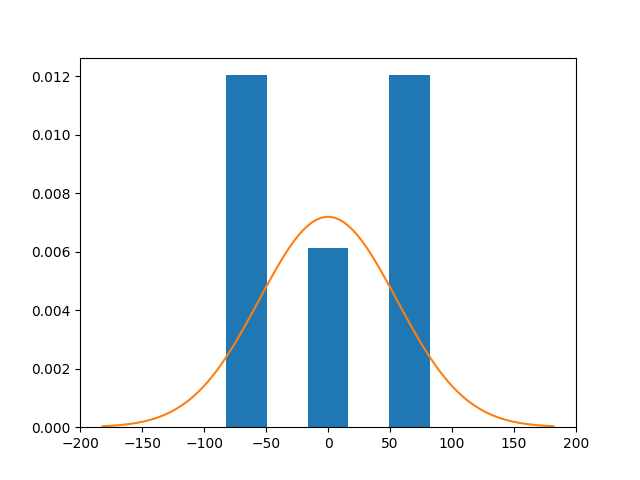

In [75]:
fig, ax = plt.subplots()

ax.hist((freqs[peak_inds]-larmor)*1e3, weights=abs(weights[peak_inds]), bins=11, density=True)
f = (np.linspace(min(freqs[peak_inds]), max(freqs[peak_inds]), 100)-larmor)*1e3

ax.plot(f, np.exp(-f**2/(2*(rss*1e3)**2))/(2e6*np.pi*rss**2)**0.5)

In [54]:
(freqs[peak_inds]-larmor)*1e3

array([  6.05096455,  56.21222857,  58.49926836, ..., -56.21222235,
       -58.49929914, -58.49933761])